# Explanation of the larger context around this notebook

See the [slides](https://github.com/Josh-Joseph/tsc-2019/tree/master/doc/TSC%202019) from [TSC 2019](https://www.tsc2019-interlaken.ch/)

# Notebook setup

In [1]:
# import the used packages/modules and call the needed jupyter notebook line magics 

import sys
sys.path.append('../src')
import numpy as np
import world
from simple_agents import DoNothingAgent, RandomAgent
from training import train_agent, load_pretrained_agent
from brain_utils import get_brain_state, visualize_weights, visualize_activations

%matplotlib inline

# The environment and the agent's "physical" form

## Intuition for the environment

[OpenAI's LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/)
- The agent is a lunar lander attempting to softly land between the flags
- Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points
- Each leg ground contact is +10
- Firing the engines is a small negative reward
- Small positive reward for smoother flight
- Fuel is infinite
- Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine

In [2]:
%%HTML
<video width="480" height="360" controls>
  <source src="videos/openai_lunarlander_video.mp4" type="video/mp4">
</video>

## Intuition for agents in the environment

In [3]:
# An agent that does nothing
    
agent = DoNothingAgent()
episode_history = world.run_episode(agent)
print("The agent recieved {} total reward".format(int(round(sum(episode_history['reward'])))))

The agent recieved -136 total reward


In [4]:
# An agent that takes random actions

agent = RandomAgent()
episode_history = world.run_episode(agent)
print("The agent recieved {} total reward".format(int(round(sum(episode_history['reward'])))))

The agent recieved -98 total reward


# Our agent

The structure of the agent:
![The structure of the agent](images/agent_structure.png)

## Semantically important regions for the agent

In [5]:
def I_am_high_above_the_ground(observation):
    return observation[1] > 0.5

def I_am_low_to_the_ground(observation):
    return observation[1] <= 0.5

def I_am_to_the_left_of_the_center(observation):
    return observation[0] > 0.

def I_am_to_the_right_of_the_center(observation):
    return observation[0] <= 0.

def I_am_falling_too_fast(observation):
    return observation[3] < -0.2

regions = [
    I_am_high_above_the_ground, 
    I_am_low_to_the_ground, 
    I_am_to_the_left_of_the_center, 
    I_am_to_the_right_of_the_center,
    I_am_falling_too_fast
]

In [6]:
def print_matching_regions(observation):
    for region in regions:
        print('{}: {}'.format(region.__name__, region(episode_history['observation'][episode_index][:8])))

I_am_high_above_the_ground: True
I_am_low_to_the_ground: False
I_am_to_the_left_of_the_center: False
I_am_to_the_right_of_the_center: True
I_am_falling_too_fast: True


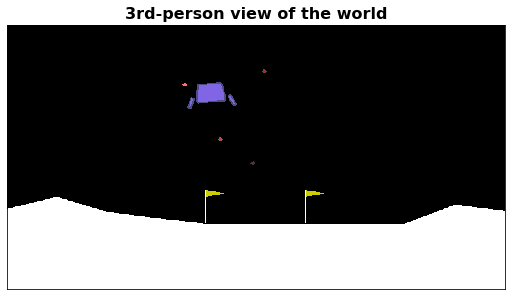

In [7]:
episode_index = 50

world.visualize(episode_history['world_image'][episode_index])

print_matching_regions(episode_history['observation'][episode_index])

## Conversion of recurrent_activations to internal state

In [8]:
def recurrent_activations_to_internal_state(recurrent_activations):
    
    internal_state = set()
    
    for activation, region in zip(recurrent_activations, regions):
        if activation > 0.5:
            internal_state.add(region.__name__)
            
    return internal_state

## Training the agent

In [9]:
# Uncomment below if you wish to retrain the agent, otherwise it will use a pretrained, saved model
# train_agent()

agent = load_pretrained_agent()

print(agent.qnetwork_local)

MentalQNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=69, out_features=128, bias=True)
  (fc3): Linear(in_features=192, out_features=5, bias=True)
  (fc4): Linear(in_features=128, out_features=4, bias=True)
)


The performance of the agent during training:
![The training performance of the agent](training_performance.png)

## The agent acting in the environment

In [10]:
episode_history = world.run_episode(agent)
print("The agent recieved {} total reward".format(int(round(sum(episode_history['reward'])))))

The agent recieved 236 total reward


# Brain state instances of the agent

In [11]:
def visualize_brain_state_instance(episode_index):

    brain_state = get_brain_state(agent, episode_history['observation'][episode_index])
    
    world.visualize(episode_history['world_image'][episode_index])
    visualize_weights(brain_state)
    visualize_activations(brain_state)

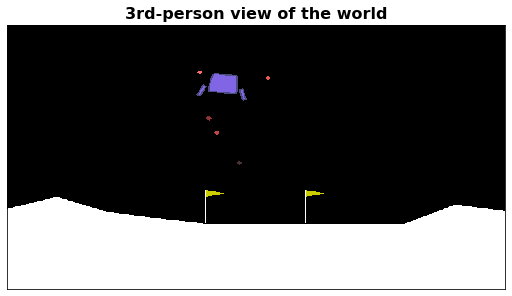

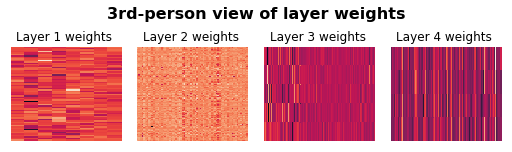

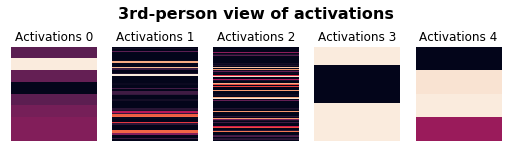

In [12]:
visualize_brain_state_instance(50)

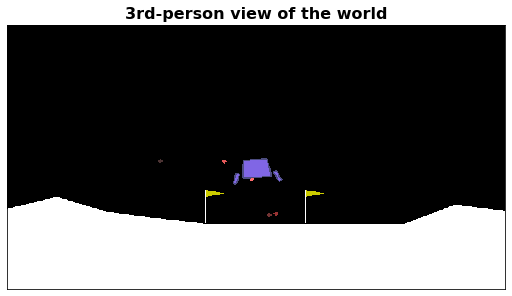

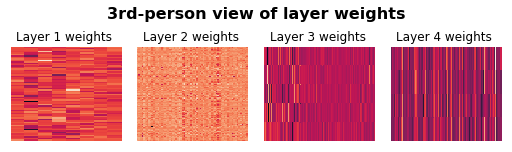

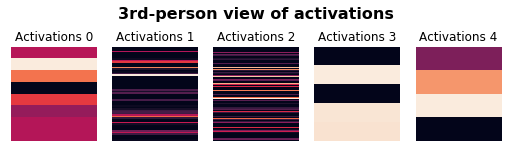

In [13]:
visualize_brain_state_instance(150)

# Internal state instances of the agent

In [14]:
def visualize_internal_state_instance(episode_index):
    
    brain_state = get_brain_state(agent, episode_history['observation'][episode_index])
    
    recurrent_activations = brain_state['activations'][3]
    internal_state = recurrent_activations_to_internal_state(recurrent_activations)
    
    print("Internal state: {}".format(internal_state))
    
    world.visualize(episode_history['world_image'][episode_index])

Internal state: {'I_am_falling_too_fast', 'I_am_to_the_right_of_the_center', 'I_am_high_above_the_ground'}


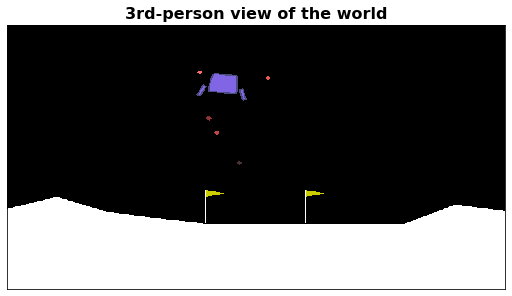

In [15]:
visualize_internal_state_instance(50)

Internal state: {'I_am_low_to_the_ground', 'I_am_to_the_left_of_the_center'}


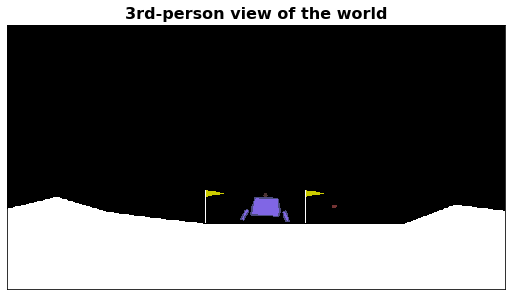

In [16]:
visualize_internal_state_instance(325)

# 3rd-person (objective) perspective

## A 3rd-person ontology over brain states

Brain state in humans and animals: the full physical-chemical state of the brain and nervous system

So we'll define a brain state of the agent as a token in the following __3rd person__ ontology:
- Layer weights
- Activations
- Connectivity
- The agent's observation
- The agent's action
- The environment
- Brain state (contains layer weights, activations, and connectivity)

The structure of the agent (blue indicates types in the 3rd person ontology):
![The structure of the agent](nn_only_blue.png)

# 1st-person (subjective) perspective

## A 1st-person ontology over mental states

Mental state in humans and animals: beliefs, desires, thoughts, perceptions, emotions, knowledge, etc.

So we'll define a mental state of the agent to be a token in the following __1st person__ ontology:
- Region
- Mental state (set of regions the agent believes it's in)

The structure of the agent (blue indicates types in the 3rd person ontology, red indicates types in the 1st person ontology):
![The structure of the agent](nn_blue_and_red.png)

# Searle's view

- Mental state types are causally reducible to brain state types
- Mental state types are ontologically irreducible to brain state types

## Causal reducibility

Phenomena of type A are causally reducible to phenomena of type B if and only if
1. the behavior of A’s are entirely casually explained by the behavior of B’s
1. A’s have no causal powers in addition to the powers of B’s

### The agent's mental state behavior is causally explained by its brain states behavior

The function `third_person_brain_state_to_first_person_mental_state` is explicitly satisfying this.

### The agent's mental states have no causal powers in addition to the powers of its brain states

By looking at the neural network structure we can see all of the causal power is captured by the activations.

## Ontological irreducibility

Phenomena of type A are ontologically reducible to phenomena of type B if and only if A’s are nothing but B’s

### The agent's mental states are not nothing but its brain states

__1st person__ ontology:
- Region
- Mental state (a set of regions)

__3rd person__ ontology:
- Layer weights
- Activations
- Connectivity
- The agent's observation
- The agent's action
- The environment
- Brain state (contains layer weights, activations, and connectivity)
- Mental state reports

TALK ABOUT BITS and abstraction levels

# Open questions

One of the contentious pieces of this was the `third_person_brain_state_to_first_person_mental_state` function. A function that went from brain state types to mental state types. One way we can see even more clearly what is happening here is to note that this notebook is essentially the same argument as:

In [17]:
brain_state = np.array(
    [[2], 
     [1]]
)

brain_state_to_mental_state_matrix = np.matrix(
    [[1, 0], 
     [0, 1], 
     [1, 1]]
)

mental_state = brain_state_to_mental_state_matrix * brain_state

print('Brain state: \n{}\n'.format(brain_state))
print('Brain state to mental state "function": \n{}\n'.format(brain_state_to_mental_state_matrix))
print('Mental state: \n{}\n'.format(mental_state))

Brain state: 
[[2]
 [1]]

Brain state to mental state "function": 
[[1 0]
 [0 1]
 [1 1]]

Mental state: 
[[2]
 [1]
 [3]]



And then noting that:
- The "mental state" was created by a simple matrix multiplication with the "brain state" (hence, causally reducible)
- The "brain state" is of type length-2-vector and the "mental state" of type length-3-vector where there is one ontology over length-2-vectors and another ontology over length-3-vectors

So we'd be very curious to get thoughts on what this type conversion _means_ in the context of Searle's view (or even more broadly). Or is this confusion because we viewed (and implemented) `third_person_brain_state_to_first_person_mental_state` as a function and should have gone about that specifying that relationship another way?